# Harmony EOSS Concise API Tutorial


## What is Concise?

Concise is a Harmony service developed by PODAAC that allows users to concatenate multiple L2 granules together into a single granule. This concatenation is done by adding a new subset_index dimension to the resulting granule.


## Before you start


Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT or Production environment, which will be used for this notebook by visiting https://uat.urs.earthdata.nasa.gov. These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.

Please setup the following environment variable for respective environment, setup in .bashrc file.

OPS_USERNAME
OPS_PASSWORD


Set up libraries needed to run demo

In [1]:
import os
from harmony import BBox, Client, Collection, Request, Environment
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

Set up collection to run concise and how many granules to concatenate

In [2]:
collection_id = 'C1940473819-POCLOUD'
max_results = 5

Retrieve credentials username and password for earthdata

In [3]:
username = os.environ.get('OPS_USERNAME')
password = os.environ.get('OPS_PASSWORD')

print

<function print>

Setup harmony client to make our harmony request with our username and password. 

Create our request with the collection we want to concatenate, set concatenate to true, how many granules we want to concatenate, set skip preview to true so job doesn't pause, and the format output we want.

Check to make sure our harmony request is valid.

In [4]:
harmony_client = Client(auth=(username, password), env=Environment.PROD)

collection = Collection(id=collection_id)

request = Request(
    collection = collection,
    concatenate = True,
    max_results = max_results,
    skip_preview = True,
    format="application/x-netcdf4",
)

request.is_valid()

True

Now that we have a valid request we simply need to call the submit function using the client we created earlier and pass in the request as a parameter.

Tip: if you want to see the request before submitting it, use the request_as_curl function on the client to get an equivalent curl command for the request that will be submitted.

In [5]:
print(harmony_client.request_as_curl(request))

job1_id = harmony_client.submit(request)

curl -X GET -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate' -H 'Authorization: *****' -H 'Connection: keep-alive' -H 'Cookie: urs_user_already_logged=yes; token=*****; _urs-gui_session=441963edbfcbcaea1579d97ef9c7864a' -H 'User-Agent: Darwin/20.6.0 python-requests/2.26.0 harmony-py/0.4.2 CPython/3.8.10' 'https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&format=application%2Fx-netcdf4&maxResults=5&concatenate=true&skipPreview=true'


After submitting the request it is possible to retrieve the current processing status by using the job ID returned from the submission.

If the request is still running, we can wait until the Harmony request has finished processing. This cell will wait until the request has finised.

In [6]:
print(f'\n{job1_id}')

print(harmony_client.status(job1_id))

print('\nWaiting for the job to finish')
results = harmony_client.result_json(job1_id, show_progress=True)


68421797-cd93-4cd6-b01a-4bf437c51f27
{'status': 'running', 'message': 'CMR query identified 2405884 granules, but the request has been limited to process only the first 5 granules because you requested 5 maxResults.', 'progress': 0, 'created_at': datetime.datetime(2022, 7, 25, 20, 40, 5, 418000, tzinfo=tzutc()), 'updated_at': datetime.datetime(2022, 7, 25, 20, 40, 6, 352000, tzinfo=tzutc()), 'created_at_local': '2022-07-25T13:40:05-07:00', 'updated_at_local': '2022-07-25T13:40:06-07:00', 'data_expiration': datetime.datetime(2022, 8, 24, 20, 40, 5, 418000, tzinfo=tzutc()), 'data_expiration_local': '2022-08-24T13:40:05-07:00', 'request': 'https://harmony.earthdata.nasa.gov/C1940473819-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&format=application%2Fx-netcdf4&maxResults=5&concatenate=true&skipPreview=true', 'num_input_granules': 5}

Waiting for the job to finish


 [ Processing: 100% ] |###################################################| [|]


After the harmony job is finished we download the resulting concatenated granule file.

In [7]:
print('\nDownloading results:')
filename = None
futures = harmony_client.download_all(job1_id, overwrite=True)
for f in futures:
    print(f)
    print(f.result())  # f.result() is a filename, in this case
    filename = f.result()
print('\nDone downloading.')


<Future at 0x1436f2c10 state=running>
C1940473819-POCLOUD_merged.nc4

Done downloading.


With the output file downloaded, now we can open concatenated granule using xarray to inspect some of the metadata. 

Note:
In some of the collections the time variable has a time dimension and when we concatenate files we add a subset_index into the time dimension which causes the time variable have two dimension. Xarray doesn't allow the time variable have two dimensions so when using xarray to open concatenated files the time variable might need to be dropped. The file can be open with netcdf library

In [22]:
#some collections time variabe has a time dimension which can cause an exception when we concatenate and makes time two dimension
try:
    ds = xr.open_dataset(filename, decode_times=False)
except xr.core.variable.MissingDimensionsError:
    ds = xr.open_dataset(filename, decode_times=False, drop_variables=['time'])

print(list(ds.variables))
    
assert len(ds.coords['subset_index']) == max_results

['subset_files', 'lat', 'lon', 'sea_surface_temperature', 'sst_dtime', 'quality_level', 'sses_bias', 'sses_standard_deviation', 'l2p_flags', 'sea_surface_temperature_4um', 'quality_level_4um', 'sses_bias_4um', 'sses_standard_deviation_4um', 'wind_speed', 'dt_analysis']


After opening the file we can use matplotlib to create a plot for each subindex where each subindex represents the data for the granule file. We will plot sea_surface_temperature for each granule using subset_index dimension.

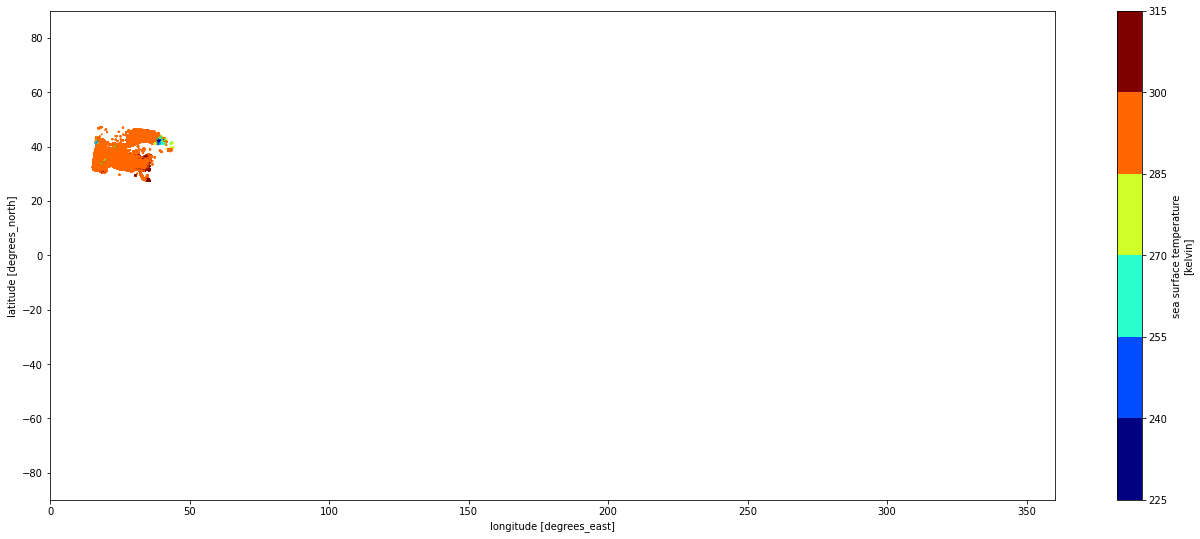

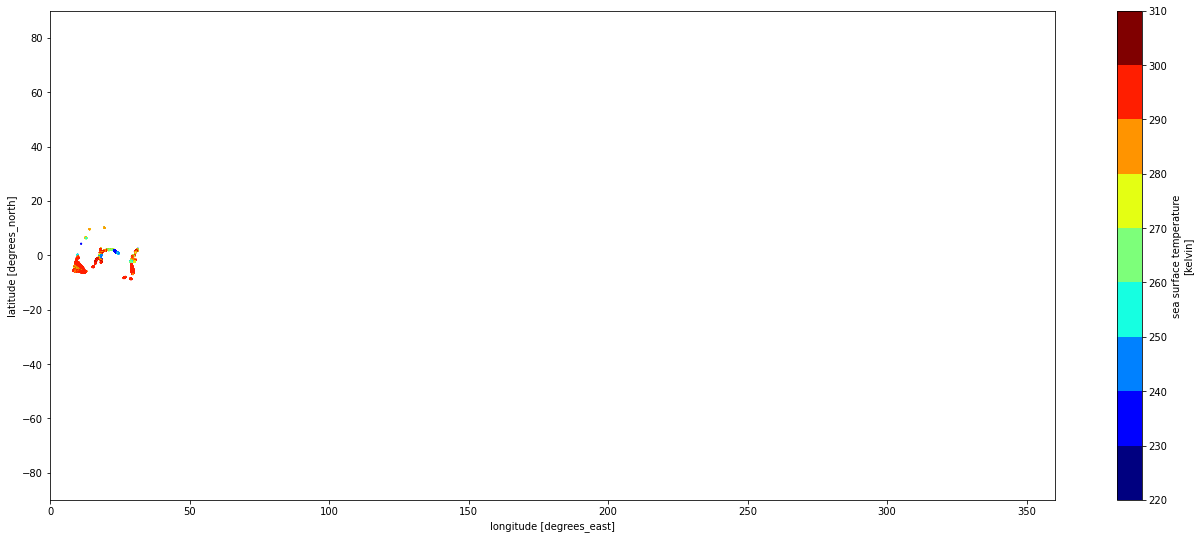

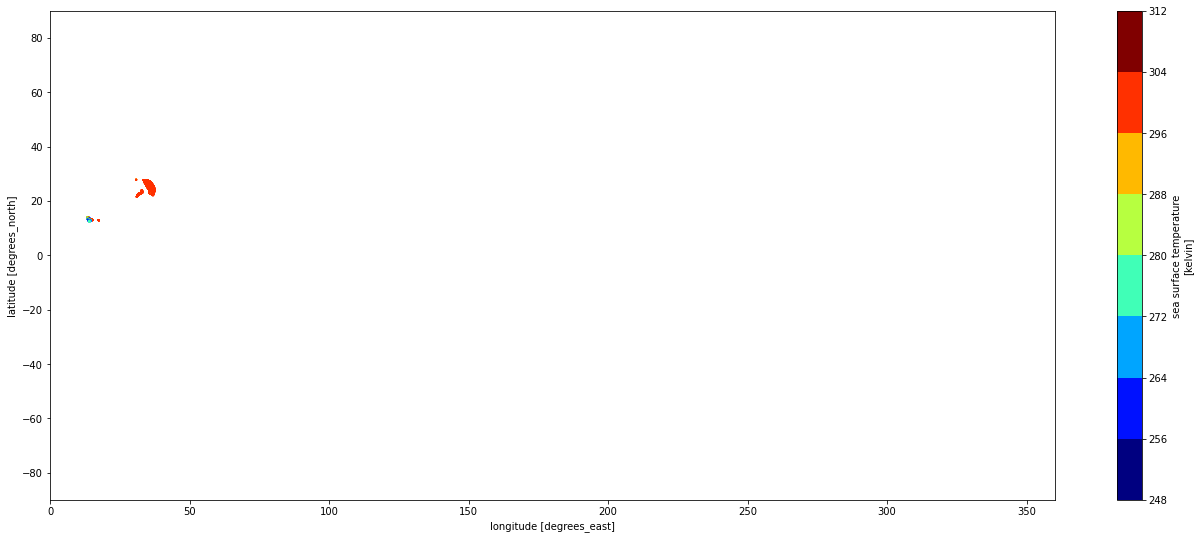

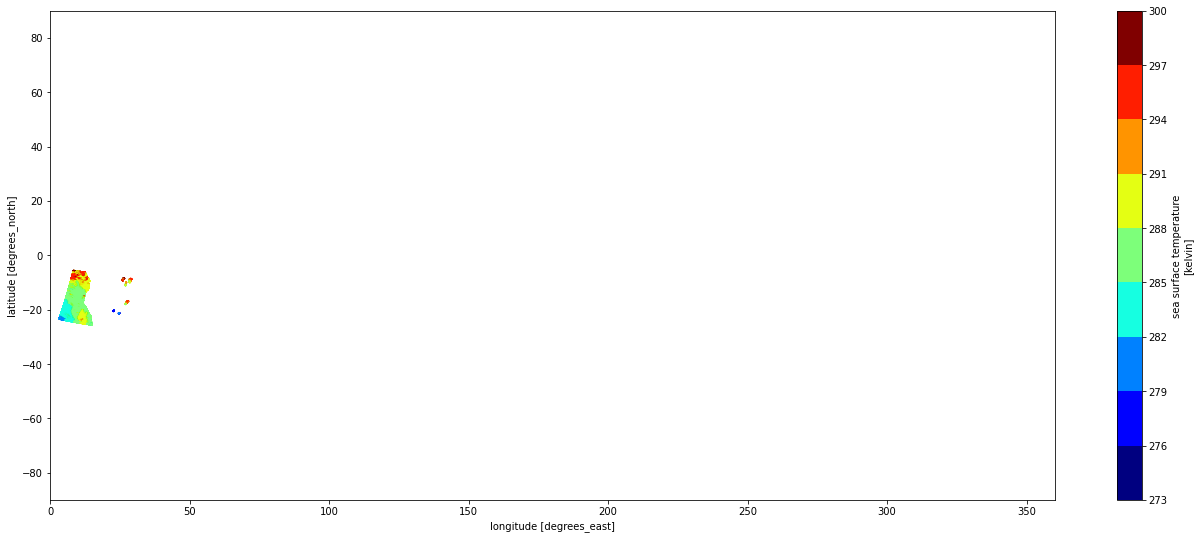

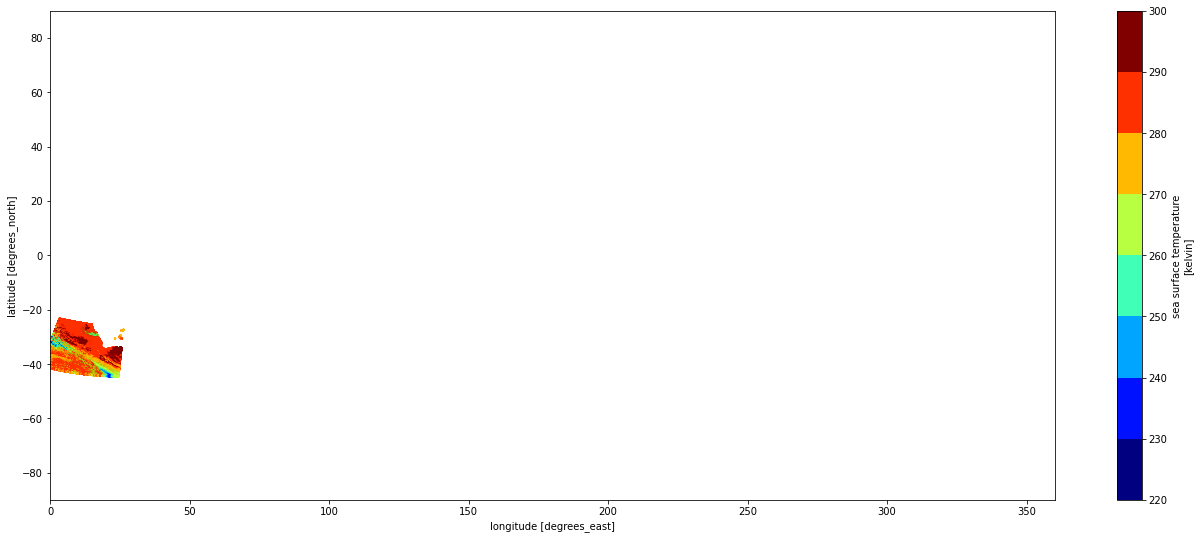

In [23]:
variable = None
for v in list(ds.variables):
    if v not in ['subset_files', 'lat', 'lon']:
        variable = v
        break;

for index in range(0, max_results):
        
    ds.isel(subset_index=index).plot.scatter(
        y="lat",
        x="lon",
        hue=variable,
        s=1,
        levels=9,
        cmap="jet",
        aspect=2.5,
        size=9
    )
    
    plt.xlim(  0., 360.)
    plt.ylim(-90.,  90.)
    plt.show()

We can also plot out the entire granule file which would plot all the data of the concatenated files.

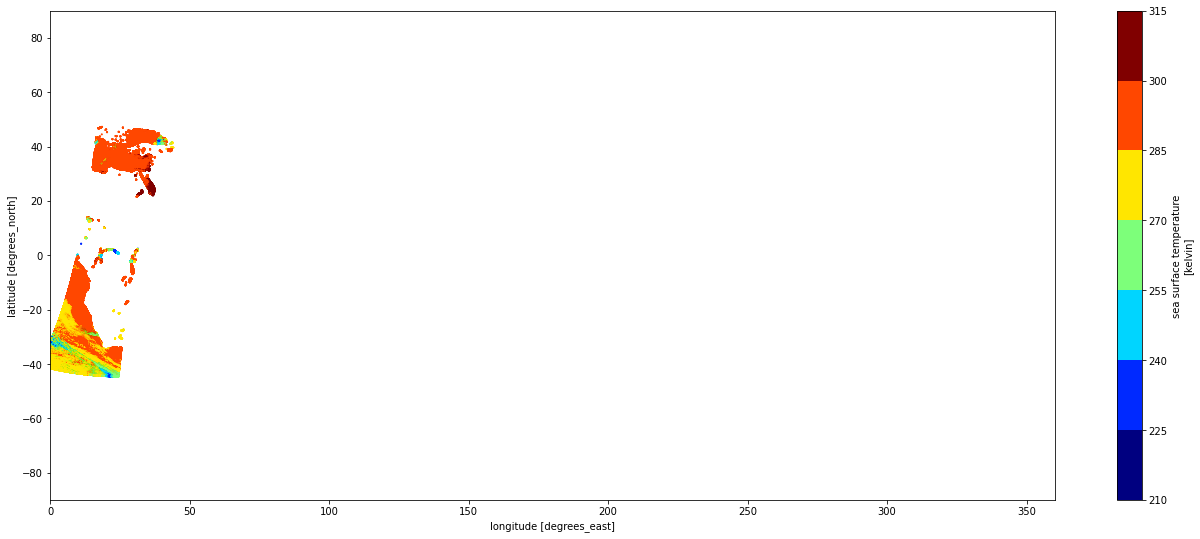

In [24]:
ds.plot.scatter(
    y="lat",
    x="lon",
    hue=variable,
    s=1,
    levels=9,
    cmap="jet",
    aspect=2.5,
    size=9
)

plt.xlim(  0., 360.)
plt.ylim(-90.,  90.)
plt.show()